[View in Colaboratory](https://colab.research.google.com/github/Shubham-kale/Data-Visualization-in-Python-Course-Assignments/blob/master/5_Model_Evaluation_and_Refinement_.ipynb)

 <a href="https://www.bigdatauniversity.com"><img src = "https://ibm.box.com/shared/static/ugcqz6ohbvff804xp84y4kqnvvk3bq1g.png" width = 300, align = "center"></a>

<h1 align=center><font size = 5>Data Analysis with Python</font></h1>

# Module 5: Model Evaluation and Refinement 

We have built models and made predictions of vehicle prices. Now we will determine how accurate these predictions are. 




# Table of content
<p></p>
<li><a href="#ref1">Model Evaluation </a></li>
<li><a href="#ref2">Over-fitting, Under-fitting and Model Selection </a></li>
<li><a href="#ref3">Ridge Regression </a></li>
<li><a href="#ref4">Grid Search</a></li>
<p></p>

In [1]:
import pandas as pd
import numpy as np

# Import clean data 
path = path='https://ibm.box.com/shared/static/q6iiqb1pd7wo8r3q28jvgsrprzezjqk3.csv'
df = pd.read_csv(path)

 First lets only use numeric data 

In [2]:
df=df._get_numeric_data()

In [3]:
df.head()

,Unnamed: 0,symboling,normalized-losses,wheel-base,length,width,height,curb-weight,engine-size,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price,city-L/100km,diesel,gas
0,0,3,122,88.6,0.811148,0.890278,48.8,2548,130,3.47,2.68,9.0,111.0,5000.0,21,27,13495.0,11.190476,0,1
1,1,3,122,88.6,0.811148,0.890278,48.8,2548,130,3.47,2.68,9.0,111.0,5000.0,21,27,16500.0,11.190476,0,1
2,2,1,122,94.5,0.822681,0.909722,52.4,2823,152,2.68,3.47,9.0,154.0,5000.0,19,26,16500.0,12.368421,0,1
3,3,2,164,99.8,0.848630,0.919444,54.3,2337,109,3.19,3.40,10.0,102.0,5500.0,24,30,13950.0,9.791667,0,1
4,4,2,164,99.4,0.848630,0.922222,54.3,2824,136,3.19,3.40,8.0,115.0,5500.0,18,22,17450.0,13.055556,0,1


 Libraries for plotting 

In [5]:
!pip install ipywidgets

    100% |████████████████████████████████| 112kB 2.5MB/s 
    100% |████████████████████████████████| 2.2MB 5.4MB/s 


In [6]:
from IPython.display import display
from IPython.html import widgets 
from IPython.display import display
from ipywidgets import interact, interactive, fixed, interact_manual
print("done")

done


## Functions for plotting 

In [7]:
def DistributionPlot(RedFunction,BlueFunction,RedName,BlueName,Title ):
    width = 12
    height = 10
    plt.figure(figsize=(width, height))

    ax1 = sns.distplot(RedFunction, hist=False, color="r", label=RedName)
    ax2 = sns.distplot(BlueFunction, hist=False, color="b", label=BlueName, ax=ax1)

    plt.title(Title)
    plt.xlabel('Price (in dollars)')
    plt.ylabel('Proportion of Cars')

    plt.show()
    plt.close()
    

In [8]:
def PollyPlot(xtrain,xtest,y_train,y_test,lr,poly_transform):
    width = 12
    height = 10
    plt.figure(figsize=(width, height))
    
    
    #training data 
    #testing data 
    # lr:  linear regression object 
    #poly_transform:  polynomial transformation object 
 
    xmax=max([xtrain.values.max(),xtest.values.max()])

    xmin=min([xtrain.values.min(),xtest.values.min()])

    x=np.arange(xmin,xmax,0.1)


    plt.plot(xtrain,y_train,'ro',label='Training Data')
    plt.plot(xtest,y_test,'go',label='Test Data')
    plt.plot(x,lr.predict(poly_transform.fit_transform(x.reshape(-1,1))),label='Predicted Function')
    plt.ylim([-10000,60000])
    plt.ylabel('Price')
    plt.legend()


<a id="ref1"></a>

# Part 1: Training and Testing

An important step in testing your model is to split your data into training and testing data. We will place the target data **price** in a separate dataframe **y**:

In [9]:
y_data=df['price']

drop price data in x data

In [10]:
x_data=df.drop('price',axis=1)
x_data.head()

,Unnamed: 0,symboling,normalized-losses,wheel-base,length,width,height,curb-weight,engine-size,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,city-L/100km,diesel,gas
0,0,3,122,88.6,0.811148,0.890278,48.8,2548,130,3.47,2.68,9.0,111.0,5000.0,21,27,11.190476,0,1
1,1,3,122,88.6,0.811148,0.890278,48.8,2548,130,3.47,2.68,9.0,111.0,5000.0,21,27,11.190476,0,1
2,2,1,122,94.5,0.822681,0.909722,52.4,2823,152,2.68,3.47,9.0,154.0,5000.0,19,26,12.368421,0,1
3,3,2,164,99.8,0.848630,0.919444,54.3,2337,109,3.19,3.40,10.0,102.0,5500.0,24,30,9.791667,0,1
4,4,2,164,99.4,0.848630,0.922222,54.3,2824,136,3.19,3.40,8.0,115.0,5500.0,18,22,13.055556,0,1


 now we randomly split our data into training and testing data  using the function **train_test_split** 

In [11]:
from sklearn.model_selection import train_test_split


x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.15, random_state=1)


print("number of test samples :", x_test.shape[0])
print("number of training samples:",x_train.shape[0])


number of test samples : 31
number of training samples: 170


The **test_size** parameter sets the proportion of data that is split into the testing set. In the above, the testing set is set to 10% of the total dataset. 

 <div class="alert alert-danger alertdanger" style="margin-top: 20px">
<h1> Question  #1): </h1>

<b> Use the function "train_test_split" to split up the data set such that 40% of the data samples will be utilized for testing, set the parameter "random_state" equal to zero. The output of the function should be the following:  "x_train_1" , "x_test_1", "y_train_1" and  "y_test_1".</b>
</div>

In [12]:
x_train1, x_test1, y_train1, y_test1 = train_test_split(x_data, y_data, test_size=0.4, random_state=0) 

 Let's import **LinearRegression** from the module **linear_model**

In [13]:
from sklearn.linear_model import LinearRegression

 We create a Linear Regression object:

In [14]:
lre=LinearRegression()

we fit the model using the feature horsepower 

In [15]:
lre.fit(x_train[['horsepower']],y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

Let's Calculate the R^2 on the test data:

In [16]:
lre.score(x_test[['horsepower']],y_test)

0.707688374146705

we can see the R^2 is much smaller using the test data.

In [17]:
lre.score(x_train[['horsepower']],y_train)

0.6449517437659684

 <div class="alert alert-danger alertdanger" style="margin-top: 20px">
<h1> Question  #2): </h1>
<b> 
Find the R^2  on the test data using 90% of the data for training data
</b>
</div>

In [18]:
x_train1, x_test1, y_train1, y_test1 = train_test_split(x_data, y_data, test_size=0.9, random_state=0)
lre.fit(x_train1[['horsepower']],y_train1)
lre.score(x_test1[['horsepower']],y_test1)


0.6559543699796797

 Sometimes you do not have sufficient testing data; as a result, you may want to perform Cross-validation. Let's  go over several methods that you can use for  Cross-validation. 

## Cross-validation Score 

Lets import **cross_val_score** from the module **model_selection**

In [19]:
from sklearn.model_selection import cross_val_score
print("done")

done


We input the object, the feature in this case ' horsepower', the target data (y_data). The parameter 'cv'  determines the number of folds; in this case 4. 

In [20]:
Rcross=cross_val_score(lre,x_data[['horsepower']], y_data,cv=4)

The default scoring is R^2; each element in the array has the average  R^2 value in the fold:

In [21]:
Rcross

array([0.7746232 , 0.51716687, 0.74785353, 0.04839605])

 We can calculate the average and standard deviation of our estimate:

In [22]:
print("The mean of the folds are", Rcross.mean(),"and the standard deviation is" ,Rcross.std())

The mean of the folds are 0.522009915042119 and the standard deviation is 0.291183944475603


 We can use negative squared error as a score by setting the parameter  'scoring' metric to 'neg_mean_squared_error'. 

In [23]:
-1*cross_val_score(lre,x_data[['horsepower']], y_data,cv=4,scoring='neg_mean_squared_error')

array([20254142.84026702, 43745493.2650517 , 12539630.34014931,
       17561927.72247591])

<div class="alert alert-danger alertdanger" style="margin-top: 20px">
<h1> Question  #3): </h1>
<b> 
Calculate the average R^2 using two folds, find the average R^2 for the second fold utilizing the horsepower as a feature : 
</b>
</div>

In [24]:
Rc=cross_val_score(lre,x_data[['horsepower']], y_data,cv=2)
Rc[1]

0.443196127755029

You can also use the function 'cross_val_predict' to predict the output. The function splits up the data into the specified number of folds, using one fold to get a prediction while the rest of the folds are used as test data. First import the function:

In [25]:
from sklearn.model_selection import cross_val_predict

 We input the object, the feature in this case **'horsepower'** , the target data **y_data**. The parameter 'cv' determines the number of folds; in this case 4.  We can produce an output:

In [26]:
yhat=cross_val_predict(lre,x_data[['horsepower']], y_data,cv=4)
yhat[0:5]

array([14141.63807508, 14141.63807508, 20814.29423473, 12745.03562306,
       14762.35027598])


<a id="ref2"></a>

# Part 2: Overfitting, Underfitting and Model Selection 

It turns out that the test data sometimes referred to as the out of sample data is a much better measure of how well your model performs in the real world.  One reason for this is overfitting; let's go over some examples. It turns out these differences are more apparent in Multiple Linear Regression and Polynomial Regression so we will explore overfitting in that context.

Let's create Multiple linear regression objects and train the model using **'horsepower'**, **'curb-weight'**, **'engine-size'** and **'highway-mpg'** as features.

In [27]:
lr=LinearRegression()
lr.fit(x_train[['horsepower', 'curb-weight', 'engine-size', 'highway-mpg']],y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

Prediction using training data:

In [28]:
yhat_train=lr.predict(x_train[['horsepower', 'curb-weight', 'engine-size', 'highway-mpg']])
yhat_train[0:5]

array([11927.70699817, 11236.71672034,  6436.91775515, 21890.22064982,
       16667.18254832])

 Prediction using test data: 

In [29]:
yhat_test=lr.predict(x_test[['horsepower', 'curb-weight', 'engine-size', 'highway-mpg']])
yhat_test[0:5]

array([11349.16502418,  5914.48335385, 11243.76325987,  6662.03197043,
       15555.76936275])

Let's perform some model evaluation using our training and testing data separately. First  we import the seaborn and matplotlibb library for plotting.

In [30]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

Let's examine the distribution of the predicted values of the training data.

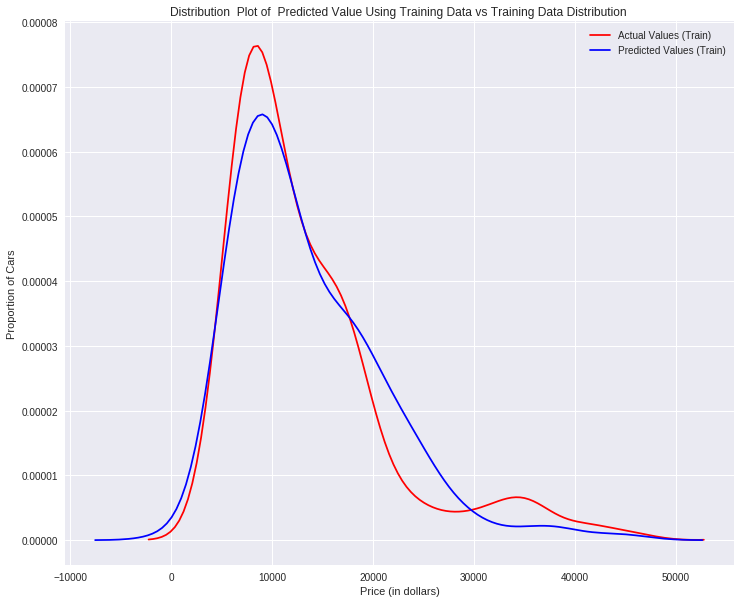

In [31]:
Title='Distribution  Plot of  Predicted Value Using Training Data vs Training Data Distribution '
DistributionPlot(y_train,yhat_train,"Actual Values (Train)","Predicted Values (Train)",Title)

 Figur 1: Plot of predicted values using the training data compared to the training data. 

So far the model seems to be doing well in learning from the training dataset. But what happens when the model encounters new data from the testing dataset? When the model generates new values from the test data, we see the distribution of the predicted values is much different from the actual target values. 

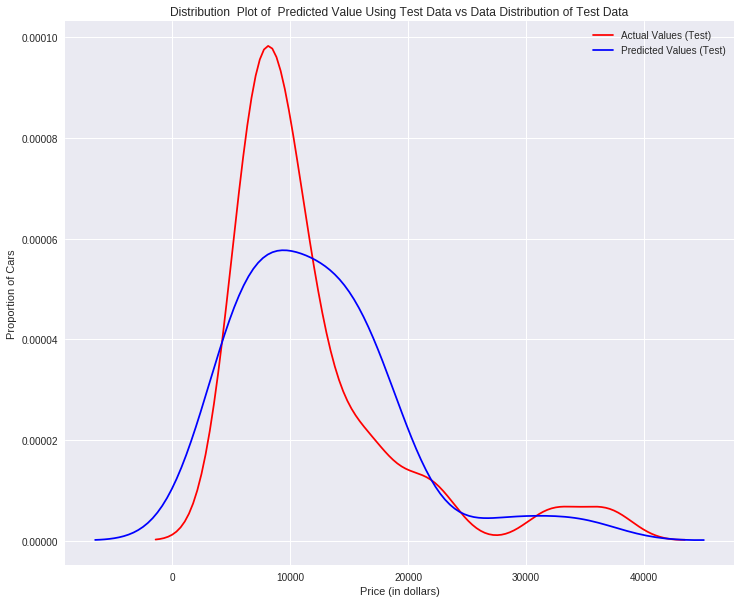

In [32]:
Title='Distribution  Plot of  Predicted Value Using Test Data vs Data Distribution of Test Data'
DistributionPlot(y_test,yhat_test,"Actual Values (Test)","Predicted Values (Test)",Title)

Figur 2: Plot of predicted value using the test data compared to the test data. 

Comparing Figure 1 and Figure 2; it is evident the distribution of the test data in Figure 1 is much better at fitting the data. This difference in Figure 2 is apparent where the ranges are from 5000 to 15 000. This is where the distribution shape is exceptionally different. Let's see if polynomial regression also exhibits a drop in the prediction accuracy when analysing the test dataset. 

In [33]:
from sklearn.preprocessing import PolynomialFeatures
print("done")

done


####  Overfitting 
Overfitting occurs when the model fits the noise, not the underlying process. Therefore when testing your model using the test-set, your model does not perform as well as it is modelling noise, not the underlying process that generated the relationship. Let's create a degree 5 polynomial model.

Let's use 55 percent of the data for testing and the rest for training:

In [34]:
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.45, random_state=0)
print("done")

done


We will perform a degree 5 polynomial transformation on the feature **'horse power'**. 

In [35]:
pr=PolynomialFeatures(degree=5)
x_train_pr=pr.fit_transform(x_train[['horsepower']])
x_test_pr=pr.fit_transform(x_test[['horsepower']])
pr

PolynomialFeatures(degree=5, include_bias=True, interaction_only=False)

Now let's create a linear regression model "poly" and train it.

In [36]:
poly=LinearRegression()
poly.fit(x_train_pr,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

 We can see the output of our model using the method  "predict." then assign the values to "yhat".

In [37]:
yhat=poly.predict(x_test_pr )
yhat[0:5]

array([ 6728.65561887,  7307.98782321, 12213.78770965, 18893.24804015,
       19995.95195136])

Let's take the first five predicted values and compare it to the actual targets. 

In [38]:
print("Predicted values:", yhat[0:4])
print("True values:",y_test[0:4].values)

Predicted values: [ 6728.65561887  7307.98782321 12213.78770965 18893.24804015]
True values: [ 6295. 10698. 13860. 13499.]


We will use the function "PollyPlot" that we defined at the beginning of the lab to display the training data, testing data, and the predicted function.

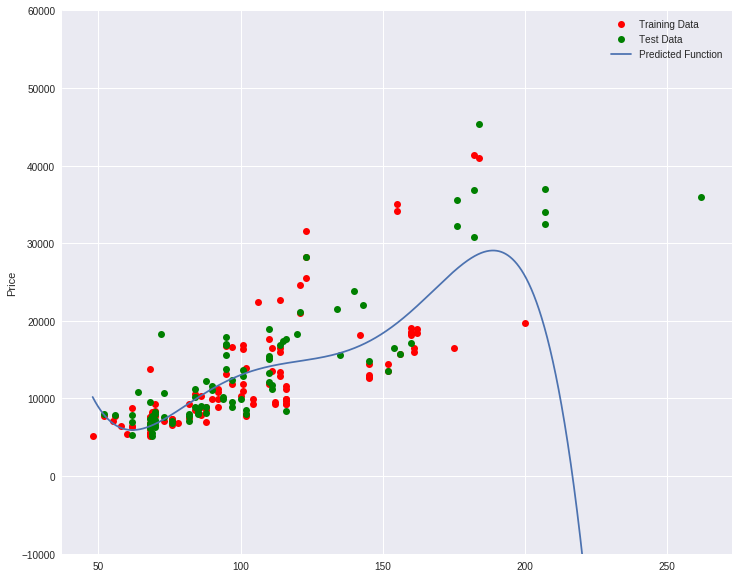

In [39]:
PollyPlot(x_train[['horsepower']],x_test[['horsepower']],y_train,y_test,poly,pr)

Figur 4 A polynomial regression model, red dots represent training data, green dots represent test data, and the blue line represents the model prediction. 

We see that the estimated function appears to track the data but around 200 horsepower, the function begins to diverge from the data points. 

 R^2 of the training data:

In [40]:
poly.score(x_train_pr, y_train)

0.556771690212023

 R^2 of the test data:

In [41]:
poly.score(x_test_pr, y_test)

-29.871340302044153

We see the R^2 for the training data is 0.5567 while the R^2 on the test data was -29.87.  The lower the R^2, the worse the model, a Negative R^2 is a sign of overfitting.

Let's see how the R^2 changes on the test data for different order polynomials and plot the results:

Text(3,0.75,'Maximum R^2 ')

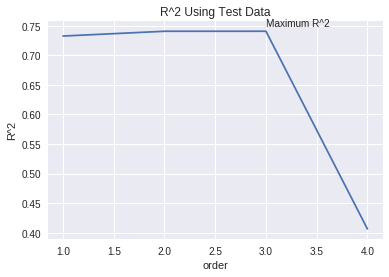

In [42]:
Rsqu_test=[]

order=[1,2,3,4]
for n in order:
    pr=PolynomialFeatures(degree=n)
    
    x_train_pr=pr.fit_transform(x_train[['horsepower']])
    
    x_test_pr=pr.fit_transform(x_test[['horsepower']])    
    
    lr.fit(x_train_pr,y_train)
    
    Rsqu_test.append(lr.score(x_test_pr,y_test))

plt.plot(order,Rsqu_test)
plt.xlabel('order')
plt.ylabel('R^2')
plt.title('R^2 Using Test Data')
plt.text(3, 0.75, 'Maximum R^2 ')    

 We see the R^2 gradually increases until an order three polynomial is used. Then the  R^2 dramatically decreases at four.

 The following function will be used in the next section; please run the cell.

In [43]:
def f(order,test_data):
    x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=test_data, random_state=0)
    pr=PolynomialFeatures(degree=order)
    x_train_pr=pr.fit_transform(x_train[['horsepower']])
    x_test_pr=pr.fit_transform(x_test[['horsepower']])
    poly=LinearRegression()
    poly.fit(x_train_pr,y_train)
    PollyPlot(x_train[['horsepower']],x_test[['horsepower']],y_train,y_test,poly,pr)


The following interface allows you to experiment with different polynomial orders and different amounts of data. 

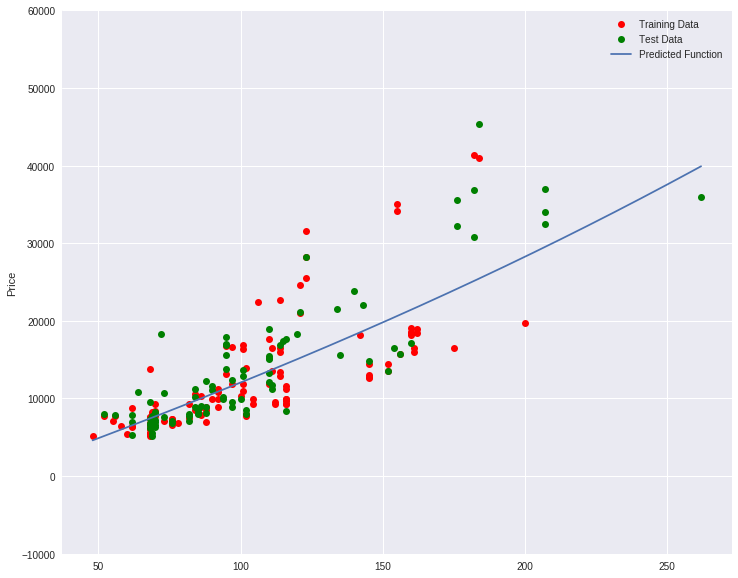

<function __main__.f>

In [44]:
interact(f, order=(0,6,1),test_data=(0.05,0.95,0.05))

 <div class="alert alert-danger alertdanger" style="margin-top: 20px">
<h1> Question  #4a): </h1>

<b> We can perform polynomial transformations with more than one feature. Create a "PolynomialFeatures" object "pr1" of degree two. ? 
?</b>
</div>

In [45]:
pr1=PolynomialFeatures(degree=2)

<div class="alert alert-danger alertdanger" style="margin-top: 20px">
<h1> Question  #4b): </h1>

<b> 
 Transform the training and testing samples for the features 'horsepower', 'curb-weight', 'engine-size' and 'highway-mpg'. Hint: use the method "fit_transform" 
?</b>
</div>

In [46]:
x_train_pr1=pr.fit_transform(x_train[['horsepower', 'curb-weight', 'engine-size', 'highway-mpg']])
x_test_pr1=pr.fit_transform(x_test[['horsepower', 'curb-weight', 'engine-size', 'highway-mpg']])

<div class="alert alert-danger alertdanger" style="margin-top: 20px">
<h1> Question  #4c): </h1>

<b> 
How many dimensions does the new feature have? Hint: use the attribute "shape"
</b>
</div>


In [47]:
x_train_pr1.shape

(110, 70)

<div class="alert alert-danger alertdanger" style="margin-top: 20px">
<h1> Question  #4d): </h1>

<b> 
Create a linear regression model "poly1" and train the object using the method "fit" using the polynomial features? </b>
</div>


In [50]:
import sklearn
poly1=sklearn.linear_model.LinearRegression().fit(x_train_pr1,y_train)

 <div class="alert alert-danger alertdanger" style="margin-top: 20px">
<h1> Question  #4e): </h1>

<b> 
 
 Use the method  "predict" to predict an output on the polynomial features, then use the function "DistributionPlot"  to display the distribution of the predicted output vs the test data?</b>
</div>

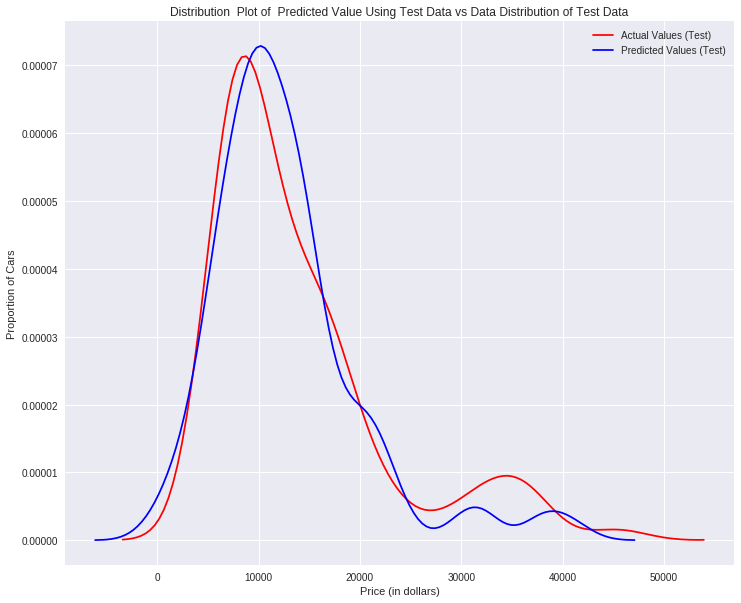

In [51]:
yhat_test1=poly1.predict(x_train_pr1)
Title='Distribution  Plot of  Predicted Value Using Test Data vs Data Distribution of Test Data'
DistributionPlot(y_test,yhat_test1,"Actual Values (Test)","Predicted Values (Test)",Title)


 <div class="alert alert-danger alertdanger" style="margin-top: 20px">
<h1> Question  #4f): </h1>

<b> 
 Use the distribution plot to determine the two regions were the predicted prices are less accurate than the actual prices.
 </div>

### The predicted value is lower than actual value for cars where the price *` $ 10,000 range, conversely the predicted price is larger than the price cost in the`* $30, 000 to `$40,000 ` range. As such the model is not as accurate in these ranges  


<!-- Your answer is below:


-->

<img src = "https://ibm.box.com/shared/static/c35ipv9zeanu7ynsnppb8gjo2re5ugeg.png" width = 700, align = "center">



<a id="ref3"></a>

## Part 3: Ridge regression 

 In this section, we will review Ridge Regression we will see how the parameter Alfa changes the model. Just a note here our test data will be used as validation data.

 Let's perform a degree two polynomial transformation on our data. 

In [52]:
pr=PolynomialFeatures(degree=2)
x_train_pr=pr.fit_transform(x_train[['horsepower', 'curb-weight', 'engine-size', 'highway-mpg','normalized-losses','symboling']])
x_test_pr=pr.fit_transform(x_test[['horsepower', 'curb-weight', 'engine-size', 'highway-mpg','normalized-losses','symboling']])

 Let's import  **Ridge**  from the module **linear models**.

In [53]:
from sklearn.linear_model import Ridge

Let's create a Ridge regression object, setting the regularization parameter to 0.1 

In [54]:
RigeModel=Ridge(alpha=0.1)

 Like regular regression, you can fit the model using the method **fit**.

In [55]:
RigeModel.fit(x_train_pr,y_train)

Ridge(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

 Similarly, you can obtain a prediction: 

In [56]:
yhat=RigeModel.predict(x_test_pr)

Let's compare the first five predicted samples to our test set 

In [57]:
print('predicted:', yhat[0:4])
print('test set :', y_test[0:4].values)

predicted: [ 6567.83081933  9597.97151399 20836.22326843 19347.69543463]
test set : [ 6295. 10698. 13860. 13499.]


 We select the value of Alfa that minimizes the test error, for example, we can use a for loop. 

In [58]:
Rsqu_test=[]
Rsqu_train=[]
dummy1=[]
ALFA=5000*np.array(range(0,10000))
for alfa in ALFA:
    RigeModel=Ridge(alpha=alfa) 
    RigeModel.fit(x_train_pr,y_train)
    Rsqu_test.append(RigeModel.score(x_test_pr,y_test))
    Rsqu_train.append(RigeModel.score(x_train_pr,y_train))

We can plot out the value of R^2 for different Alphas 

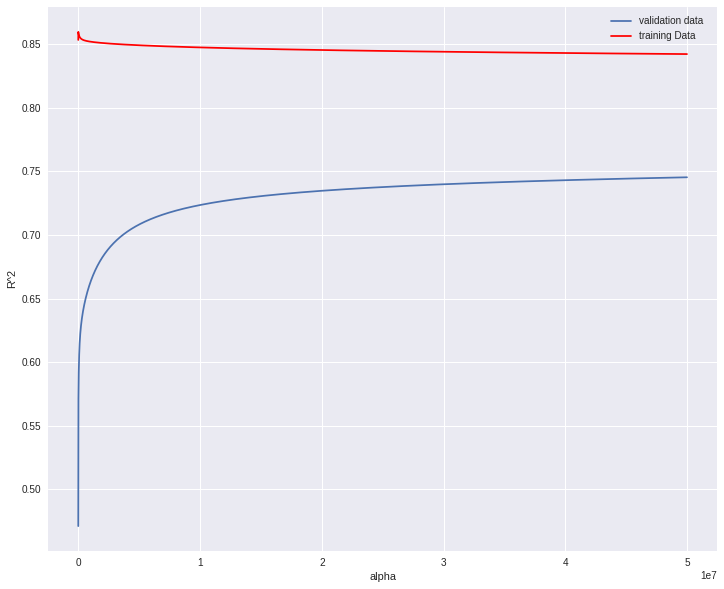

In [59]:
width = 12
height = 10
plt.figure(figsize=(width, height))

plt.plot(ALFA,Rsqu_test,label='validation data  ')
plt.plot(ALFA,Rsqu_train,'r',label='training Data ')
plt.xlabel('alpha')
plt.ylabel('R^2')
plt.legend()


  Figure 6:The blue line represents the R^2 of the test data, and the red line represents the R^2 of the training data. The x-axis represents the different values of Alfa 

 The red line in figure 6 represents the  R^2 of the test data, as Alpha increases the R^2 decreases; therefore as Alfa increases the model performs worse on the test data.  The blue line represents the R^2 on the validation data, as the value for Alfa increases the R^2 decreases.   

<div class="alert alert-danger alertdanger" style="margin-top: 20px">
<h1> Question  #5): </h1>

Perform Ridge regression and calculate the R^2 using the polynomial features, use the training data to train the model and test data to test the model. The parameter alpha should be set to  10.
</div>

In [60]:
RigeModel=Ridge(alpha=0) 
RigeModel.fit(x_train_pr,y_train)
RigeModel.score(x_test_pr, y_test)


0.47098333063511094

<a id="ref4"></a>

## Part 4: Grid Search

The term Alfa is a hyperparameter, sklearn has the class  **GridSearchCV** to make the process of finding the best hyperparameter simpler.

 Let's import **GridSearchCV** from  the module **model_selection**

In [61]:
from sklearn.model_selection import GridSearchCV
print("done")

done


We create a dictionary of parameter values:

In [62]:
parameters1= [{'alpha': [0.001,0.1,1, 10, 100, 1000,10000,100000,100000]}]
parameters1

[{'alpha': [0.001, 0.1, 1, 10, 100, 1000, 10000, 100000, 100000]}]

Create a ridge regions object:

In [63]:
RR=Ridge()
RR

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

Create a ridge grid search object 

In [64]:
Grid1 = GridSearchCV(RR, parameters1,cv=4)

Fit the model 

In [65]:
Grid1.fit(x_data[['horsepower', 'curb-weight', 'engine-size', 'highway-mpg']],y_data)

GridSearchCV(cv=4, error_score='raise',
       estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'alpha': [0.001, 0.1, 1, 10, 100, 1000, 10000, 100000, 100000]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

The object finds the best parameter values on the validation data. We can obtain the estimator with the best parameters and assign it to the variable BestRR as follows:

In [66]:
BestRR=Grid1.best_estimator_
BestRR

Ridge(alpha=10000, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

 We now test our model on the test data 

In [67]:
BestRR.score(x_test[['horsepower', 'curb-weight', 'engine-size', 'highway-mpg']],y_test)

0.8411649831036152

<div class="alert alert-danger alertdanger" style="margin-top: 20px">
<h1> Question  #6): </h1>
Perform a grid search for the alpha parameter and the normalization parameter, then find the best values of the parameters

</div>

In [69]:
parameters2= [{'alpha': [0.001,0.1,1, 10, 100, 1000,10000,100000,100000],'normalize':[True,False]} ]
Grid2 = GridSearchCV(Ridge(), parameters2,cv=4)
Grid2.fit(x_data[['horsepower', 'curb-weight', 'engine-size', 'highway-mpg']],y_data)
Grid2.best_estimator_

Ridge(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=True, random_state=None, solver='auto', tol=0.001)

# About the Authors:  

This notebook written [Joseph Santarcangelo PhD]( https://www.linkedin.com/in/joseph-s-50398b136/)

Copyright &copy; 2017 [cognitiveclass.ai](cognitiveclass.ai?utm_source=bducopyrightlink&utm_medium=dswb&utm_campaign=bdu). This notebook and its source code are released under the terms of the [MIT License](https://bigdatauniversity.com/mit-license/).
